In [4]:
import numpy as np
from keras.layers import Input, Dense, Reshape, Flatten, Dropout, LSTM, Embedding
from keras.layers import BatchNormalization, Activation, MaxPooling2D
from keras.layers.advanced_activations import LeakyReLU
from keras.models import Sequential, Model
from keras.optimizers import RMSprop, Adam
import keras.backend as K
import matplotlib.pyplot as plt
from keras.datasets import imdb, reuters
from keras.preprocessing import sequence
from sklearn.model_selection import train_test_split
from keras.utils import to_categorical
from keras.preprocessing.text import Tokenizer
import os

**Question 1: IMDB Dataset**

In [5]:
max_features = 10000
max_len = 1000

(x_train, y_train), (x_test, y_test) = imdb.load_data(num_words=max_features,)

x_train = sequence.pad_sequences(x_train, maxlen=max_len)
x_test = sequence.pad_sequences(x_test, maxlen=max_len)

# print(x_train.shape)
# print(y_train.shape)

batch_size = 32
epochs = 20

x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.33, random_state=42)

#Creating Plot function
def plot_progress(history):
  history_dict = history.history
  accuracy = history_dict['acc']
  val_accuracy = history_dict['val_acc']
  loss = history_dict['loss']
  val_loss = history_dict['val_loss']

  fig = plt.figure(figsize=(15,7))
  plt.subplot(1,2,1)
  plt.plot(range(epochs), accuracy, 'r', label = 'Train Accuracy')
  plt.plot(range(epochs), val_accuracy, 'b', label = 'Validation Accuracy')
  plt.legend()

  plt.subplot(1,2,2)
  plt.plot(range(epochs), loss, 'r', label = 'Train Loss')
  plt.plot(range(epochs), val_loss, 'b', label = 'Validation Loss')

  plt.legend()
  plt.show()

#Model with Trainable Embedding Layer
model = Sequential()
model.add(Embedding(max_features, 32, input_length=max_len))
model.add(Flatten())
model.add(Dense(64, activation = 'relu'))
model.add(Dense(1, activation = 'sigmoid'))

#Model Compile
model.compile(optimizer = 'Adam',
             loss = 'binary_crossentropy',
             metrics = ['acc'])
model.summary()
# print(x_val.shape)
#Model Fit
history = model.fit(x_train, y_train,
                   epochs = epochs,
                   batch_size = batch_size,
                   validation_data=(x_val, y_val))

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 1000, 32)          320000    
_________________________________________________________________
flatten_2 (Flatten)          (None, 32000)             0         
_________________________________________________________________
dense_3 (Dense)              (None, 64)                2048064   
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 65        
Total params: 2,368,129
Trainable params: 2,368,129
Non-trainable params: 0
_________________________________________________________________


/opt/conda/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Train on 16750 samples, validate on 8250 samples
Epoch 1/20
16750/16750 [==============================] - 4s 248us/step - loss: 0.4273 - acc: 0.7866 - val_loss: 0.2816 - val_acc: 0.8818
Epoch 2/20
16750/16750 [==============================] - 3s 168us/step - loss: 0.1305 - acc: 0.9552 - val_loss: 0.3026 - val_acc: 0.8790
Epoch 3/20
16750/16750 [==============================] - 3s 169us/step - loss: 0.0221 - acc: 0.9959 - val_loss: 0.3763 - val_acc: 0.8741
Epoch 4/20
16750/16750 [==============================] - 3s 184us/step - loss: 0.0030 - acc: 0.9998 - val_loss: 0.4418 - val_acc: 0.8758
Epoch 5/20
16750/16750 [==============================] - 3s 176us/step - loss: 6.9994e-04 - acc: 1.0000 - val_loss: 0.4858 - val_acc: 0.8744
Epoch 6/20
16750/16750 [==============================] - 3s 179us/step - loss: 3.1058e-04 - acc: 1.0000 - val_loss: 0.5165 - val_acc: 0.8742
Epoch 7/20
16750/16750 [==============================] - 3s 179us/step - loss: 1.7194e-04 - acc: 1.0000 - val_loss

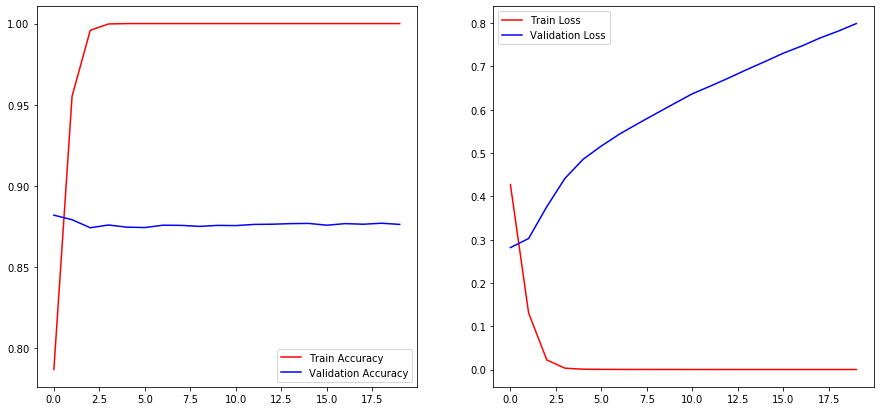

In [6]:
#Creating plot for model with trainable embedding layer
plot_progress(history)

In [7]:
#Prepare IMDB data for creating Glove Embeddings matrix
imdb_dir = '/kaggle/input/imdbdata/aclImdb'
train_dir = os.path.join(imdb_dir, 'train')
labels = []
texts = []
for label_type in ["neg", "pos"]:
    dir_name = os.path.join(train_dir, label_type)
    for fname in os.listdir(dir_name):
        if fname [-4:] == ".txt":
            f = open(os.path.join(dir_name, fname), encoding='utf-8')
            texts.append(f.read())
            f.close()
            if label_type == "neg":
                labels.append(0)
            else:
                labels.append(1)

maxlen = 100
training_samples = 200 
validation_samples = 10000 
max_words = 10000 

tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(texts)
sequences = tokenizer.texts_to_sequences(texts)
word_index = tokenizer.word_index                   
print("Found %s unique tokens." % len(word_index))

data = sequence.pad_sequences(sequences, maxlen=maxlen)

labels = np.asarray(labels)
print("Shape of data tensor:", data.shape)
print("Shape of label tensor:", labels.shape)

indices = np.arange(data.shape[0]) 
np.random.shuffle(indices)
data = data[indices]
labels = labels[indices]

x_train_2 = data[:training_samples] 
y_train_2 = labels[:training_samples] 
x_val_2 = data[training_samples:training_samples+validation_samples] 
y_val_2 = labels[training_samples:training_samples+validation_samples] 

#Create the Embedding Matrix
glove_dir = '/kaggle/input/glovedata'
embeddings_index = {}
f = open(os.path.join(glove_dir, 'glove.6B.100d.txt'))

for line in f:
  values = line.split()
  word = values[0]
  coefs = np.asarray(values[1:], dtype = 'float32')
  embeddings_index[word] = coefs
  
f.close()

len(embeddings_index)


embedding_dim = 100 

embedding_matrix = np.zeros((max_words, embedding_dim))
for word, i in word_index.items():
    if i < max_words:
        embedding_vector = embeddings_index.get(word) 
        if embedding_vector is not None:
            embedding_matrix[i] = embedding_vector 
            
#Creating model with pre-trained glove embedding weights
model2 = Sequential()
model2.add(Embedding(max_words, embedding_dim, input_length = maxlen)) 
model2.add(Flatten())
model2.add(Dense(64, activation = 'relu'))
model2.add(Dense(1, activation = 'sigmoid'))

model2.layers[0].set_weights([embedding_matrix])
model2.layers[0].trainable = False

model2.compile(optimizer = 'Adam',
             loss = 'binary_crossentropy',
             metrics = ['acc'])
model2.summary()
# print(x_val.shape)
#Model Fit
history = model2.fit(x_train_2, y_train_2,
                     epochs = epochs,
                     batch_size = batch_size,
                     validation_data=(x_val_2, y_val_2))

Found 88582 unique tokens.
Shape of data tensor: (25000, 100)
Shape of label tensor: (25000,)
Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, 100, 100)          1000000   
_________________________________________________________________
flatten_3 (Flatten)          (None, 10000)             0         
_________________________________________________________________
dense_5 (Dense)              (None, 64)                640064    
_________________________________________________________________
dense_6 (Dense)              (None, 1)                 65        
Total params: 1,640,129
Trainable params: 640,129
Non-trainable params: 1,000,000
_________________________________________________________________
Train on 200 samples, validate on 10000 samples
Epoch 1/20
200/200 [==============================] - 1s 4ms/step - loss: 1.3992 - acc: 0.4500

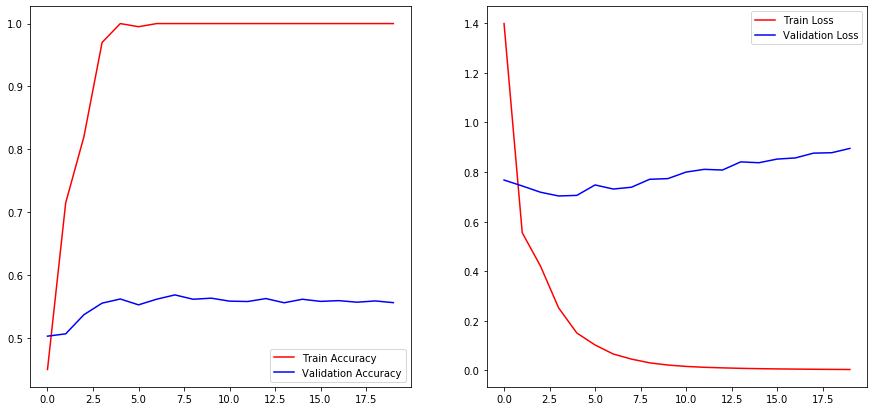

In [8]:
#Plot
plot_progress(history)

In [9]:
#LSTM model with trainable embedding layer
# max_len = 1000
# x_train = sequence.pad_sequences(x_train, maxlen=max_len)
# print(x_train.shape)
print(x_val.shape)
print(x_train.shape)
model3 = Sequential()
model3.add(Embedding(max_features, 32, input_length = max_len))
model3.add(LSTM(32))
# model3.add(Flatten())
model3.add(Dense(1, activation = 'sigmoid'))

#model compile
model3.compile(optimizer = 'Adam',
             loss = 'binary_crossentropy',
             metrics = ['acc'])
model3.summary()
# print(x_train.shape)
#Model Fit
history = model3.fit(x_train, y_train,
                     epochs = epochs,
                     batch_size = 256,
                     validation_data = (x_val, y_val))

(8250, 1000)
(16750, 1000)
Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_4 (Embedding)      (None, 1000, 32)          320000    
_________________________________________________________________
lstm_1 (LSTM)                (None, 32)                8320      
_________________________________________________________________
dense_7 (Dense)              (None, 1)                 33        
Total params: 328,353
Trainable params: 328,353
Non-trainable params: 0
_________________________________________________________________


ValueError: Input arrays should have the same number of samples as target arrays. Found 16750 input samples and 200 target samples.

In [ ]:
#Plot
plot_progress(history)

**Question 2: Reuters Dataset**

In [ ]:
max_features = 10000
max_len = 100

(x_train, y_train), (x_test, y_test) = reuters.load_data(num_words=max_features,)

x_train = sequence.pad_sequences(x_train, maxlen=max_len)
x_test = sequence.pad_sequences(x_test, maxlen=max_len)

y_train = to_categorical(y_train)
y_test = to_categorical(y_test)
# print(x_train.shape)
# print(y_train.shape)

batch_size = 256
epochs = 20

x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.33, random_state=42)

#Model with trainable embedding layer
model = Sequential()
model.add(Embedding(max_features, 32, input_length=max_len))
model.add(Flatten())
model.add(Dense(64, activation = 'relu'))
model.add(Dense(46, activation = 'softmax'))

#model compile
model.compile(optimizer = 'Adam',
             loss = 'categorical_crossentropy',
             metrics = ['acc'])

model.summary()

#model fit
history = model.fit(x_train, y_train,
                   epochs = epochs,
                   batch_size = batch_size,
                   validation_data=(x_val, y_val))

In [ ]:
plot_progress(history)

In [ ]:
#model with pre-trained glove embedding layer
model2 = Sequential()
model2.add(Embedding(max_words, embedding_dim, input_length = maxlen)) 
model2.add(Flatten())
model2.add(Dense(64, activation = 'relu'))
model2.add(Dense(46, activation = 'softmax'))

model2.layers[0].set_weights([embedding_matrix])
model2.layers[0].trainable = False

#model compile
model2.compile(optimizer = 'Adam',
             loss = 'categorical_crossentropy',
             metrics = ['acc'])

model2.summary()

#model fit
history = model2.fit(x_train, y_train,
                     epochs = epochs,
                     batch_size = 256,
                     validation_data=(x_val, y_val))


In [ ]:
plot_progress(history)

In [ ]:
#LSTM with trainable embedding layer
model3 = Sequential()
model3.add(Embedding(max_features, 32, input_length=max_len))
#model3.add(Flatten())
model3.add(LSTM(32))
model3.add(Dense(46, activation = 'softmax'))

#model compile
model3.compile(optimizer = 'Adam',
             loss = 'categorical_crossentropy',
             metrics = ['acc'])

model3.summary()

#model fit
history = model3.fit(x_train, y_train,
                     epochs = epochs,
                     batch_size = 256,
                     validation_data=(x_val, y_val))

In [ ]:
plot_progress(history)

In [ ]:
model3 = Sequential()
model3.add(Embedding(max_features, 32, input_length=max_len))
model3.add(LSTM(64, return_sequences = True))
model3.add(LSTM(32))
model3.add(Dense(46, activation = 'softmax'))


model3.compile(optimizer = 'Adam',
             loss = 'categorical_crossentropy',
             metrics = ['acc'])

model3.summary()

history = model3.fit(x_train, y_train,
                     epochs = epochs,
                     batch_size = 256,
                     validation_data=(x_val, y_val))

In [ ]:
plot_progress(history)